In [706]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle
import json
import string
import re
from collections import defaultdict

from random import randint, shuffle
from tqdm import tqdm

import numpy as np
import nltk
import pandas as pd
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 7
np.random.seed(seed)
pd.set_option('max_colwidth', -1)

In [535]:
def load_data(filename):
    with open(f"{filename}.json", "rb") as f:
        data = json.load(f)
    print("Loaded data!")
    return data
        
def load_df(filename):
    with open(f"{filename}.pkl", "rb") as f:
        d = pickle.load(f)
    return d
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
    
i1b = lambda m : m['commentary']['innings1']['balls']
i2b = lambda m : m['commentary']['innings2']['balls']
i1o = lambda m : m['commentary']['innings1']['over_summaries']
i2o = lambda m : m['commentary']['innings2']['over_summaries']
df, players = load_df("dale_df"), load_data('player_table')

all_names = set()
ambigNames = set(['short', 'ball', 'head', 'little', 'chase', 'cutting', 'cross'])
for profile in players.values():
    name = profile['known_as'].split(' ')
    ambig = any(n.lower() in ambigNames for n in name)
    if not ambig:
        all_names.update(name)
        all_names.update([n.lower() for n in name])

Loaded data!


## Feature Engineering

In [536]:
df.head()

,desc_,hand_,length_,line_,outcome_
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0
1,"Steyn to Jaques, good length but down leg, Jaques drives, no runs, fielded by Botha",1,3,3,0
2,"Steyn to Jaques, short of a length outside the off stump, Jaques plays no shot, no runs, fielded by Boucher",1,4,1,0
3,"(no ball) Steyn to Jaques, good length delivery just outside the off stump, Jaques lets it go past, no runs, fielded by Boucher",1,3,1,4
4,"Steyn to Jaques, fuller length outside the off stump , Jaques drives in air over cover fielder, 4 runs",1,2,1,12


In [648]:
from nltk.corpus import stopwords as st
exceptions = ['a', 'off', 'against', 'between', 'into', 'through', 'above', 'below', 'up', 'down', 'out', 'in', 'over', 'further', 'of', 'on']
stopwords = set(st.words('english'))
for w in exceptions:
    stopwords.remove(w) 

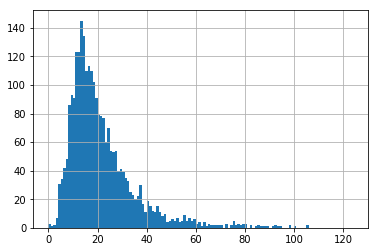

In [649]:
df['tokens'] = df['desc_'].apply(text_to_word_sequence)
lens = df['tokens'].apply(len)
lens.hist(bins=[x for x in range(125)])

In [650]:
def deleteLowCount(t, threshold):
    lcw = [w for w,c in t.word_counts.items() 
           if c < threshold  or w in all_names  or any(i.isdigit() for i in w)]
    print(f"{len(lcw)} low counted, {len(t.word_counts) - len(lcw)} left")
    for w in lcw:
        del t.word_index[w]
        del t.word_docs[w]
        del t.word_counts[w]
    return t

In [651]:
#Remove Stopwords
df['tokens_sw'] = df['tokens'].apply(lambda d: [w for w in d if w not in stopwords])

t = Tokenizer()
t.fit_on_texts(df['tokens_sw'])
t = deleteLowCount(t, 5)
rT = dict(map(reversed, t.word_index.items()))
df['sequence'] = t.texts_to_sequences(df['tokens_sw'])
filtered = df['sequence'].apply(lambda x: [rT[num] for num in x])

t = Tokenizer()
t.fit_on_texts(filtered)
df['sequence'] = t.texts_to_sequences(filtered)
rT = dict(map(reversed, t.word_index.items()))
numDistinctWords = len(t.word_index) + 1

df['tokenized_common'] = df['sequence'].apply(lambda x: ' '.join([rT[num] for num in x]))

4417 low counted, 963 left


In [652]:
word_vectorizer = CountVectorizer(ngram_range=(1,7), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['tokenized_common'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [653]:
print(freq.loc['outside off'])

frequency    611
Name: outside off, dtype: int64


In [693]:
def get_feature_importances(model, analyzer, ngram_range=(1,2), lowercase=True, min_df=10, sampsize=2000, category='length_'):
    tfv = TfidfVectorizer(min_df=min_df,
                          strip_accents='unicode',
                          analyzer=analyzer,
                          ngram_range=ngram_range,
                          lowercase=lowercase
                         )
    df_sample = df.sample(sampsize, random_state=seed)
    X = tfv.fit_transform(df_sample.tokenized_common)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X)
    terms = tfv.get_feature_names()
    var_imp = pd.DataFrame(index=terms)
    #multiclassif
    for cat in range(0,max(df_sample[category])+1):
        y = df_sample[category].apply(lambda x: 1 if x == cat else 0).values
        model.fit(X, y)
        var_imp[cat] =  np.sqrt(scaler.var_) * model.coef_[0]
        
    var_imp['freq'] = pd.Series(var_imp.index.map(lambda x: freq.loc[x]['frequency']), index=var_imp.index) #Attach frequency of ngram to importance
    return var_imp

model = LogisticRegression()
var_imp = get_feature_importances(model, analyzer='word', ngram_range=(2,6), lowercase=True, min_df=5, category='line_')

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [694]:
var_imp.sort_values(2, ascending=False).head(20)

,0,1,2,3,4,freq
on off,-0.060913,-0.164970,0.182706,-0.035798,-0.015187,191
square leg,-0.050007,-0.163467,0.163482,0.005149,-0.011801,103
mid on,-0.056661,-0.123761,0.160012,-0.036349,-0.009774,85
off stump,-0.064595,-0.101067,0.146358,-0.049382,-0.022651,342
on middle,-0.036263,-0.116866,0.135622,-0.027121,-0.007007,95
deep midwicket,-0.024710,-0.082388,0.105455,-0.018201,-0.004780,30
full on,-0.031096,-0.086179,0.102273,-0.020976,-0.005731,71
on off stump,-0.032802,-0.088507,0.100378,-0.024332,-0.006801,106
length on,-0.026292,-0.077715,0.090802,-0.020308,-0.005482,96
through midwicket,-0.022706,-0.071481,0.089953,-0.018067,-0.003955,23


In [724]:
ngramsImportant = set()
numTop = 40
for l in range(0, len(var_imp.columns)-1):
    sortedByL = var_imp.sort_values(l, ascending=False)
    ngramsImportant.update(list(sortedByL.iloc[:numTop].index))
print(f"{len(ngramsImportant)} important ngrams!")
ngramsImportant = list(ngramsImportant)

174 important ngrams!


In [725]:
def ngramsInText(text):
    ngramPresence = dict()
    for ngram in ngramsImportant:
        ngramSplit = ngram.split(' ')
        ngramPresence[ngram] = int(tuple(ngramSplit) in set(nltk.ngrams(text.split(' '), len(ngramSplit))))
    return pd.Series(ngramPresence)

ngramPresenceDf = df['tokenized_common'].apply(lambda text: ngramsInText(text))

In [726]:
# df.reset_index(drop=True, inplace=True)
# ngramPresenceDf.reset_index(drop=True, inplace=True)
df_train = pd.concat([df, ngramPresenceDf], axis=1)
df_train.head()

,desc_,hand_,length_,line_,outcome_,tokens,tokens_sw,sequence,tokenized_common,change of,...,off back,off stump,side wide,pull shot,middle off,fine leg boundary,on up,wide length ball,of width,middle leg
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0,"[steyn, to, jaques, full, and, on, the, legs, swinging, in, jaques, lets, it, go, past, no, runs, fielded, by, boucher]","[steyn, jaques, full, on, legs, swinging, in, jaques, lets, go, past, runs, fielded, boucher]","[14, 3, 479, 202, 5, 191, 68, 56, 50, 170]",full on legs swinging in lets go past runs fielded,0,...,0,0,0,0,0,0,0,0,0,0
1,"Steyn to Jaques, good length but down leg, Jaques drives, no runs, fielded by Botha",1,3,3,0,"[steyn, to, jaques, good, length, but, down, leg, jaques, drives, no, runs, fielded, by, botha]","[steyn, jaques, good, length, down, leg, jaques, drives, runs, fielded, botha]","[15, 6, 16, 10, 69, 50, 170]",good length down leg drives runs fielded,0,...,0,0,0,0,0,0,0,0,0,0
2,"Steyn to Jaques, short of a length outside the off stump, Jaques plays no shot, no runs, fielded by Boucher",1,4,1,0,"[steyn, to, jaques, short, of, a, length, outside, the, off, stump, jaques, plays, no, shot, no, runs, fielded, by, boucher]","[steyn, jaques, short, of, a, length, outside, off, stump, jaques, plays, shot, runs, fielded, boucher]","[11, 4, 1, 6, 7, 2, 12, 109, 62, 50, 170]",short of a length outside off stump plays shot runs fielded,0,...,0,1,0,0,0,0,0,0,0,0
3,"(no ball) Steyn to Jaques, good length delivery just outside the off stump, Jaques lets it go past, no runs, fielded by Boucher",1,3,1,4,"[no, ball, steyn, to, jaques, good, length, delivery, just, outside, the, off, stump, jaques, lets, it, go, past, no, runs, fielded, by, boucher]","[ball, steyn, jaques, good, length, delivery, outside, off, stump, jaques, lets, go, past, runs, fielded, boucher]","[8, 15, 6, 31, 7, 2, 12, 191, 68, 56, 50, 170]",ball good length delivery outside off stump lets go past runs fielded,0,...,0,1,0,0,0,0,0,0,0,0
4,"Steyn to Jaques, fuller length outside the off stump , Jaques drives in air over cover fielder, 4 runs",1,2,1,12,"[steyn, to, jaques, fuller, length, outside, the, off, stump, jaques, drives, in, air, over, cover, fielder, 4, runs]","[steyn, jaques, fuller, length, outside, off, stump, jaques, drives, in, air, over, cover, fielder, 4, runs]","[64, 6, 7, 2, 12, 69, 5, 149, 27, 20, 115, 50]",fuller length outside off stump drives in air over cover fielder runs,0,...,0,1,0,0,0,0,0,0,0,0


## Model

In [739]:
X_features = ngramsImportant
y_features = 'line_'

In [740]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
# X, X_test, y, y_test = train_test_split(df_train[X_features], df_train[y_features], stratify = df_train[y_features], test_size=0.15, random_state=seed)
# X, X_test = X.values, X_test.values
# y = y.values

X, y = df_train[X_features].values, df_train[y_features].values
# pca = PCA(n_components=50)
# X = pca.fit_transform(X)
# print(np.cumsum(pca.explained_variance_ratio_))
print(X.shape)
# print(f"X shape: {X.shape}, X_test shape: {X_test.shape}\ny shape: {y.shape}, y_test.shape: {y_test.shape}")

(2611, 174)


In [741]:
names = ["Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Neural Net"]

classifiers = [
    SVC(kernel="linear", C=0.05),
    SVC(gamma='scale', C=1),
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=20, n_estimators=10, max_features=6),
    MLPClassifier(alpha=1, max_iter=2000)]

# Separate models

In [743]:
scores = defaultdict(list)
for name, clf in zip(names, classifiers):
    for i, (train_fold, test_fold) in enumerate(skf.split(X,y)):
        train_x, test_x = X[train_fold], X[test_fold]
        train_y, test_y = y[train_fold], y[test_fold]
        clf.fit(train_x, train_y)
        acc = clf.score(test_x, test_y)
        scores[name].append(acc)
    print(f"Done {name} - {acc:<.2f}!")

Done Linear SVM - 0.73!
Done RBF SVM - 0.76!
Done Decision Tree - 0.76!
Done Random Forest - 0.74!
Done Neural Net - 0.80!


In [ ]:
for name, s in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<20} - {np.array(s).mean():<.3f}")

In [738]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

weights = []
for name, s in scores.items():
    m = np.array(s).mean()
    weights.append(m)
weights = np.array(weights)
weights = weights / weights.sum()
weights

array([0.19894865, 0.19945377, 0.19238587, 0.19985362, 0.20935808])

# Ensemble

In [734]:
names = ["Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Neural Net"]

classifiers_ensemble = [
    SVC(kernel="linear", C=0.05, probability=True),
    SVC(gamma='scale', C=1, probability=True),
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=20, n_estimators=10, max_features=6),
    MLPClassifier(alpha=1, max_iter=2000)
]

scores_ensemble = []
for i, (train_fold, test_fold) in enumerate(skf.split(X,y)):
    train_x, test_x = X[train_fold], X[test_fold]
    train_y, test_y = y[train_fold], y[test_fold]
#     class_weights = class_weight.compute_class_weight('balanced', np.unique(train_y), np.ravel(train_y))
#     class_weights = dict(enumerate(class_weights))
    clf_preds = []
    for i, (name, clf) in enumerate(zip(names, classifiers_ensemble)):
#         clf.class_weight = class_weights
        clf.fit(train_x, train_y)
        clf_preds.append(clf.predict_proba(test_x))
        
    
    clf_preds = np.array(clf_preds)
    weighted_clf_preds = []
    for idx, model in enumerate(clf_preds):
        weighted_clf_preds.append(model * weights[idx])
    weighted_clf_preds = np.array(weighted_clf_preds).sum(axis=0)
    
    clf_class_preds = weighted_clf_preds.argmax(axis=1)
    report = classification_report(test_y, clf_class_preds, output_dict=True)
    conf_mat = confusion_matrix(clf_class_preds, test_y)
    acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
    scores_ensemble.append([report, acc])
    print(f"Fold {i+1} = {acc:.3f}!")

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5 = 0.761!


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5 = 0.720!


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5 = 0.801!


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5 = 0.820!


KeyboardInterrupt: 

In [ ]:
print(f'Avg acc: {np.array([x[1] for x in scores_ensemble]).mean():>.3f}')

In [ ]:
def getClassPrecisions(scores):
    classReport = {}
    for lth in range(0, len(np.unique(train_y))):
        classReport[lth] = {}
        classReport[lth]['precision'] = 0
        classReport[lth]['recall'] = 0
        for report, acc in scores:
            classReport[lth]['precision'] += report[str(lth)]['precision']
            classReport[lth]['recall'] += report[str(lth)]['recall']
        classReport[lth]['precision'] /= 10
        classReport[lth]['recall'] /= 10
    return classReport

In [ ]:
for cl, report in sorted(getClassPrecisions(scores_ensemble).items(), key=lambda x:x[1]['recall']):
    print(f"{cl:<1} | got {report['precision']*100:>5.1f}% right and found {report['recall']*100:>5.1f}% of the ones available")

In [495]:
save_data(classifiers_ensemble, "model_list_trained")